# Chapter 5. Support Vector Machines

SVM models are capable of performing linear and nonlinear classification, regression, and outlier detection.
They are especially well-suited for classification of complex small- or medium-sized data sets.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

np.random.seed(0)

plt.style.use('seaborn-whitegrid')

In [2]:
%matplotlib inline

## Linear SVM classification

The SVM can be thought of as fitting the widest possible "street" between classes, thus separating the classes by staying as far away as possible from the training data.
This method is called *large margin classification*.
Further, adding more training instances outside of this margin does not affect the decision boundary.
Instead, it is fully determined by the instances on the ends of the margin; these are the *support vectors*.

### Soft margin classification

Strictly imposing that all instances must be outside of the margin is called *hard margin classification*.
This is only possible for linearly separable data and is sensitive to outliers (i.e. not robust).
Instead, a *soft margin classification* model finds a good balance between keeping the margin wide (good separation of classes) and limiting the margin "violations."
Of the SVM hyperparameters exposed by Scikit-Learn, `C` controls this balance; a lower value for `C` results in a "softer" margin (more violations are allowed).

The following is an example of using a linear SVM.

In [3]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()

# Petal length and width.
X = iris.data[:, (2, 3)]

# Labels for if the flower is Virginica
y = (iris.target == 2).astype(np.float64)

# Make a pipeline for the SVM classifier.
svm_clf = Pipeline([
    ('standard_scalar', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge'))
])

# Train the model.
svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('standard_scalar',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [4]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

The following code finds the support vectors and plots the decisions boundary for the trained model.

The decision boundary can be found for the line 

$$
y = mx + b
$$

where 

$$
m = - \frac{\mathbf{W}[0]}{\mathbf{W}[1]} \\
b = \frac{\mathbf{I}[0]}{\mathbf{W}[1]}
$$

and `W = svc.coef_[0]` and `I = svc.intercept_`.

In [5]:
svm_model = svm_clf.named_steps['linear_svc']
scaler = svm_clf.named_steps['standard_scalar']

# The offset of the data introduced by scaling.
b = svm_model.decision_function([-scaler.mean_ / scaler.scale_])
# The coefficients of the model with the scaling removed.
w = svm_model.coef_[0] / scaler.scale_

# An indicator variable:
#    1 for Virginica,
#   -1 for not Virginica
t = y * 2 - 1

# The support vecotrs are where the confidence is less than 1.
scores = t  * (X.dot(w) + b)
scores[49:53]

array([7.83527559, 0.99994532, 0.8712898 , 0.49995899])

In [6]:
support_vectors_idx = (scores < 1).ravel()
support_vectors = X[support_vectors_idx]

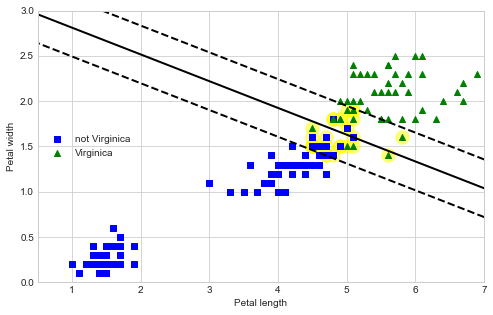

In [7]:
fig = plt.figure(figsize=(8, 5))

pal = [
    {'color':'blue', 'marker':'s', 'label': 'not Virginica'},
    {'color':'green', 'marker':'^', 'label': 'Virginica'}
]

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    #   => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -(w[0] / w[1] * x0) - (b / w[1])

    margin = 1 / w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, color='yellow', alpha=0.5)
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

svm_model.intercept_ = np.array([b])
svm_model.coef_ = np.array([w])
svm_model.support_vectors_ = X[support_vectors_idx]
plot_svc_decision_boundary(svm_model, 0, 9)

for i in range(len(pal)):
    plt.scatter(X[:, 0][y == i], X[:, 1][y == i],
                color=pal[i]['color'], 
                marker=pal[i]['marker'], 
                label=pal[i]['label'])
    

    
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.legend(loc='center left')
plt.axis([0.5, 7, 0, 3])
plt.show()

## Nonlinear SVM Classification

There are often circumstances where the data is not linearly separable.
A common solution is to use a linear SVM model in a polynomial space like in Chapter 4.

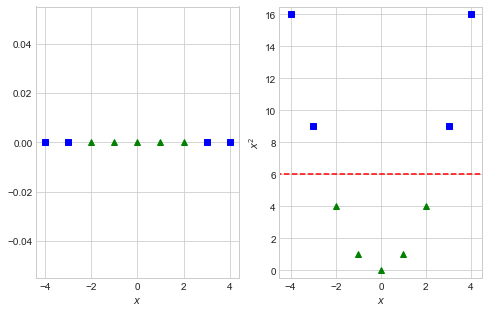

In [8]:
X_ex = np.arange(-4, 5, 1)
y_ex = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

fig = plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.plot(X_ex[y_ex == 0], np.zeros(len(X_ex))[y_ex == 0], 'bs')
plt.plot(X_ex[y_ex == 1], np.zeros(len(X_ex))[y_ex == 1], 'g^')
plt.xlabel('$x$')

plt.subplot(1, 2, 2)
plt.plot(X_ex[y_ex == 0], (X_ex**2)[y_ex == 0], 'bs')
plt.plot(X_ex[y_ex == 1], (X_ex**2)[y_ex == 1], 'g^')
plt.plot(np.linspace(-5, 5, 500), np.ones(500)*6, 'r--')
plt.axis([-4.5, 4.5, -0.5, 16.5])
plt.xlabel('$x$')
plt.ylabel('$x^2$')

plt.show()

Below is an example of this method using the moons dataset.

In [9]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.2)

polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=10, loss='hinge'))
])

polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

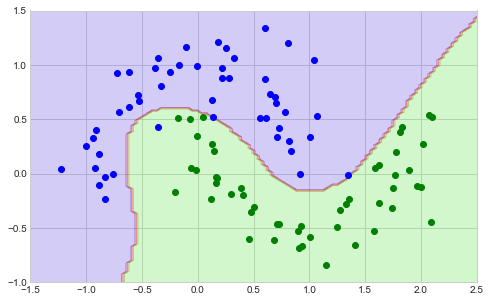

In [61]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)


fig = plt.figure(figsize=(8, 5))
axes = [-1.5, 2.5, -1, 1.5]
plt.axis(axes)

plot_predictions(polynomial_svm_clf, axes)
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'bo')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'go')

There are drawbacks to using the polynomial features to find the linear separation in higher dimensions:

- At a low polynomial, the method will be insufficient for very complex data sets.
- At a high polynomial, the number of features will cause the model to be too slow.

This can be avoided by employing the *kernel trick*.
An example is shown below and the topic is discussed in more detail, later.

In [62]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])

poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, cache_size=200, class_weight=None, coef0=1,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

The degree of the kernel can be increased or decreased to ensure the model does not under- or overfit.
The model hyperparameter `coef0` controls how much the model is influenced by high-degree polynomials vs low-degree polynomials.

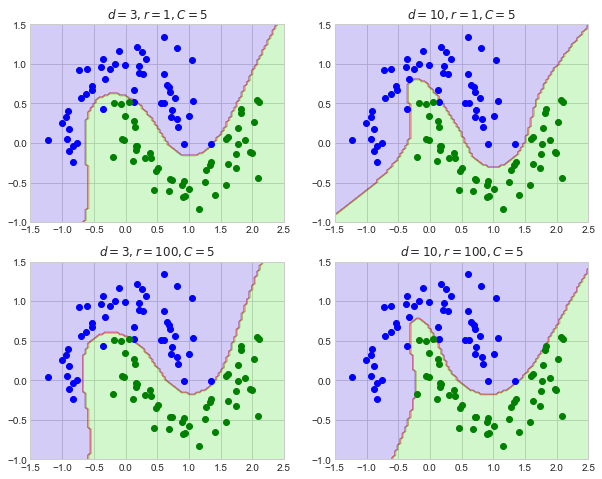

In [63]:
def plot_svc_model(d, r, C=5):
    svc_clf = Pipeline([
        ('scaler', StandardScaler()),
        ('svm_clf', SVC(kernel='poly', degree=d, coef0=r, C=C))
    ])
    svc_clf.fit(X, y)
    
    axes = [-1.5, 2.5, -1, 1.5]
    plt.axis(axes)

    plot_predictions(svc_clf, axes)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'bo')
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'go')
    plt.title(f'$d={d}, r={r}, C={C}$')

fig = plt.figure(figsize=(10, 8))

ex_model_params = [
    {'d': 3, 'r': 1, 'C': 5},
    {'d': 10, 'r': 1, 'C': 5},
    {'d': 3, 'r': 100, 'C': 5},
    {'d': 10, 'r': 100, 'C': 5},
]
for i in range(len(ex_model_params)):
    plt.subplot(2, 2, i+1)
    plot_svc_model(**ex_model_params[i])

plt.show()

A grid search can help to find the best hyperparamters; this is demonstrated below.

In [13]:
from sklearn.model_selection import GridSearchCV

# Parameter space to search in.
param_grid = {
    'svm_clf__degree': list(range(1, 20, 1)),
    'svm_clf__coef0': list(range(5, 101, 5))
}

poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])

grid_search = GridSearchCV(poly_kernel_svm_clf,
                           param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svm_clf',
                                        SVC(C=5, cache_size=200,
                                            class_weight=None, coef0=1,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='poly', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
               

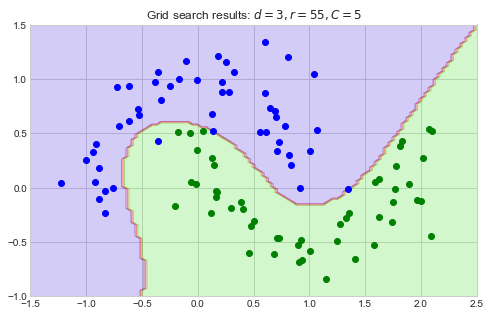

In [64]:
fig = plt.figure(figsize=(8, 5))
axes = [-1.5, 2.5, -1, 1.5]
plt.axis(axes)

plot_predictions(grid_search.best_estimator_, axes)
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'bo')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'go')

d = grid_search.best_params_['svm_clf__degree']
r = grid_search.best_params_['svm_clf__coef0']
plt.title(f'Grid search results: $d={d}, r={r}, C=5$')

plt.show()

## Similarity features

Another approach to creating a linearly separable feature space is to use a *similarity function* that measures how much each instance resembles a "landmark."
For example, the following equation is the *Guassian Radial Basis Function* (RBF).

$$
\phi(\mathbf{x}, \ell) = e^{-\gamma |\mathbf{x} - \ell|^2}
$$

Below is an example of the new feature space when then transformation is applied with the landmark $x_1 = -2, x_2 = 1$.

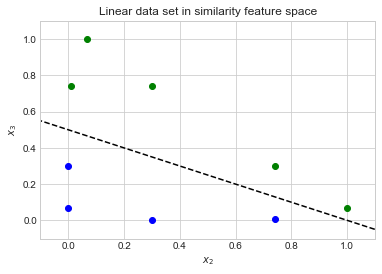

In [65]:
def calculate_rbf(x, l, gamma=0.3):
    return np.exp(-gamma * (np.abs(x - l)**2))

x2 = calculate_rbf(X_ex, l=-2)
x3 = calculate_rbf(X_ex, l=1)


plt.plot(x2[y_ex==0], x3[y_ex==0], 'bo')
plt.plot(x2[y_ex==1], x3[y_ex==1], 'go')

x_line = np.linspace(-1, 2, 500)
y_line = [0.5 - 0.5 * a for a in x_line]
plt.plot(x_line, y_line, 'k--')

plt.xlabel('$x_2$')
plt.ylabel('$x_3$')
plt.title('Linear data set in similarity feature space')

plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.show()

The trick, however, is choosing approriate landmarks.
It is often simplest to set each data point as an individual landmark, but this leads to very high-dimensional data.

### Guassian RBF kernel

The Guassian RBF can be computationally prohibitive if employed on large data sets and using each instance as a landmark.
Therefore, a kernel is often a good substitute.

In [66]:
rbf_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=5, C=0.0001))
])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=5,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

The $\gamma$ hyperparameter controls the width of the Guassian: a larger value makes the curve narrower, reducing the influence of each landmark.
Thus, it behaves like a regularization parameter.

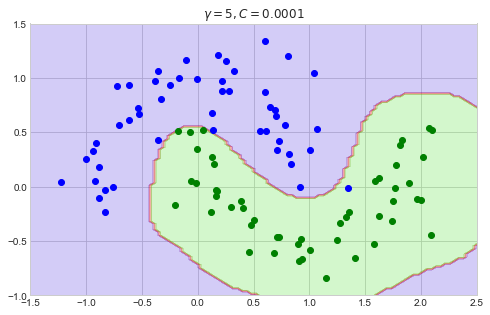

In [76]:
fig = plt.figure(figsize=(8, 5))
axes = [-1.5, 2.5, -1, 1.5]
plt.axis(axes)

def plot_rbf_svm(svc, axes):
    plot_predictions(svc, axes)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'bo')
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'go')

    gamma = svc.named_steps['svm_clf'].gamma
    C = svc.named_steps['svm_clf'].C
    plt.title(f'$\gamma={gamma}, C={C}$')

    
plot_rbf_svm(rbf_kernel_svm_clf, axes)
plt.show()

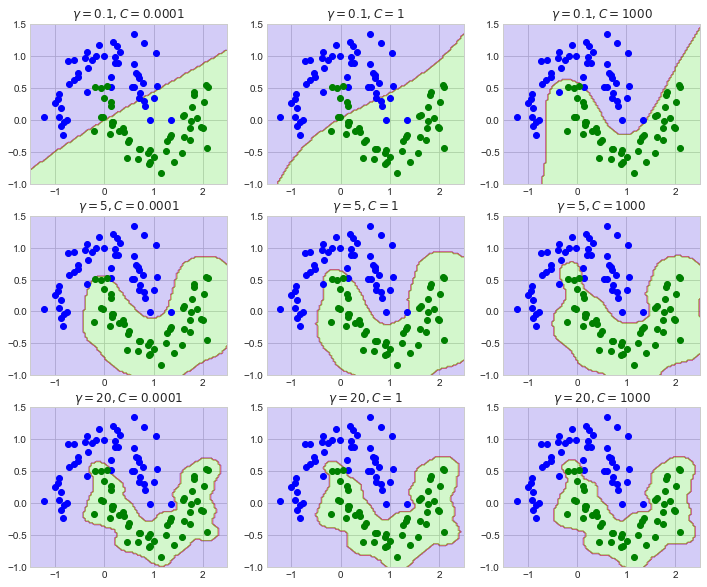

In [80]:
param_grid = [
    {'gamma': 0.1, 'C': 0.0001},
    {'gamma': 0.1, 'C': 1},
    {'gamma': 0.1, 'C': 1000},
    {'gamma': 5, 'C': 0.0001},
    {'gamma': 5, 'C': 1},
    {'gamma': 5, 'C': 1000},
    {'gamma': 20, 'C': 0.0001},
    {'gamma': 20, 'C': 1},
    {'gamma': 20, 'C': 1000},
]

fig = plt.figure(figsize=(12, 10))
axes = [-1.5, 2.5, -1, 1.5]

for i in range(len(param_grid)):
    rbf_clf = Pipeline([
        ('scaler', StandardScaler()),
        ('svm_clf', SVC(kernel='rbf', **param_grid[i]))
    ])
    rbf_clf.fit(X, y)
    
    plt.subplot(3, 3, i+1)
    plot_rbf_svm(rbf_clf, axes)
    plt.axis(axes)

    
plt.show()

As $\gamma$ and C increase, the model fits the data tighter and tighter, presenting the possibility of overfitting.
Grid search should be used to determine the optimal hyperparameters.
Below is the result of using extreme values for `gamma` and `C`.

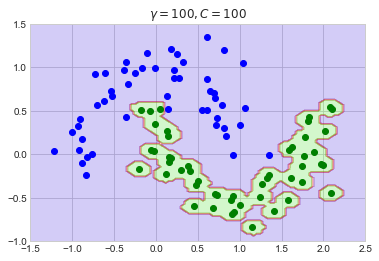

In [85]:
axes = [-1.5, 2.5, -1, 1.5]

rbf_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=100, C=100))
])
rbf_clf.fit(X, y)

plot_rbf_svm(rbf_clf, axes)
plt.axis(axes)
    
plt.show()

## SVM regression